In [241]:
import torch
import torch.nn.functional as F         # Functional PyTorch 
import matplotlib.pyplot as plt         # for making figures
%matplotlib inline

In [242]:
# Here we will import the list with all the words/names 
import os 
words_txt_file_path = os.path.join(os.path.expanduser("~"), "NN_zero_to_hero", "Lectures", "Makemore_repo", "names.txt")
words = open(words_txt_file_path, 'r').read().splitlines()

print(f"Now we have read the {len(words)} words from the file. Here we display the first 8 words\n{words[:8]}")

Now we have read the 32033 words from the file. Here we display the first 8 words
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [243]:
### Here we are building the vocabulary and mapping from char to integer and vice versa 
chars = sorted(list(set(''.join(words))))           # Read all unique characters in all words 
s_to_i = {s:i+1 for i,s in enumerate(chars)}        # Create a mapping from char to index integer
s_to_i['.'] = 0                                     # Assign the index of our special start/end token '.' to 0
i_to_s = {i:s for s,i in s_to_i.items()}            # Reverse the mapping from integer to char 
num_classes = len(s_to_i)                           # Read the different number of characters available in our dataset 

print(f"Now we have created the mappings between chars and integers and vice versa, which yields to {num_classes} different, possible characters (i.e. classes) in our dataset:\n{s_to_i=}\n{i_to_s=}")

Now we have created the mappings between chars and integers and vice versa, which yields to 27 different, possible characters (i.e. classes) in our dataset:
s_to_i={'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
i_to_s={1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [244]:
##### Build the dataset
block_size = 3                          # context length: how many characters do we take to predict the next one?
X, Y = [], []                           # Initiate lists to store the integers for the context and target examples 
for w_idx, w in enumerate(words[:5]):   # To begin with, we will only use the first five words in our dataset 
  context = [0] * block_size            # Create a list of 0's of the same size as block_size. This will be overwritten later.
  for ch in w + '.':                    # For every character in the current word + the special 'end' dot token ... 
    ix = s_to_i[ch]                     # ... read the corresponding integer index 
    X.append(context)                   # ... append the context indices to the X list 
    Y.append(ix)                        # ... append the target index to the Y list 
    if w_idx<=1:
      print("Characters:".ljust(13) + f"{''.join(i_to_s[i] for i in context)} ---> {i_to_s[ix]}".ljust(15), end="\t")
      print(f"Indices:".ljust(9) + f"{context}".ljust(12) + f"---> {ix}")
    context = context[1:] + [ix]  # crop and append the new character to the context list 

# Convert the training context list and target list into torch tensors 
X = torch.tensor(X)
Y = torch.tensor(Y)

# Print the metadata 
print(f"\nThe training data: X.shape: {X.shape} with dtype: {X.dtype}")
print(f"The target data: Y.shape: {Y.shape} with dtype: {Y.dtype}")

Characters:  ... ---> e     	Indices: [0, 0, 0]   ---> 5
Characters:  ..e ---> m     	Indices: [0, 0, 5]   ---> 13
Characters:  .em ---> m     	Indices: [0, 5, 13]  ---> 13
Characters:  emm ---> a     	Indices: [5, 13, 13] ---> 1
Characters:  mma ---> .     	Indices: [13, 13, 1] ---> 0
Characters:  ... ---> o     	Indices: [0, 0, 0]   ---> 15
Characters:  ..o ---> l     	Indices: [0, 0, 15]  ---> 12
Characters:  .ol ---> i     	Indices: [0, 15, 12] ---> 9
Characters:  oli ---> v     	Indices: [15, 12, 9] ---> 22
Characters:  liv ---> i     	Indices: [12, 9, 22] ---> 9
Characters:  ivi ---> a     	Indices: [9, 22, 9]  ---> 1
Characters:  via ---> .     	Indices: [22, 9, 1]  ---> 0

The training data: X.shape: torch.Size([32, 3]) with dtype: torch.int64
The target data: Y.shape: torch.Size([32]) with dtype: torch.int64


In [245]:
from typing import Union 
import random

# Convert the building of the dataset into a function 
def build_dataset(words, block_size: int = 3, num_words: Union[int, None] = None):  
  X, Y = [], []
  for w in (words if num_words is None else words[:num_words]):

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = s_to_i[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


# Randomly shuffle the words in_place 
random.seed(42)                                 # Choose a seed for deterministic shuffling 
random.shuffle(words)                           # inplace shuffling of the words list 
n1 = int(0.8*len(words))                        # Extract an integer for the 80% of the dataset 
n2 = int(0.9*len(words))                        # Extract an integer for the 90% of the dataset 

# Build  the different dataset splits 
Xtr, Ytr = build_dataset(words[:n1])            # Build the training split 
Xdev, Ydev = build_dataset(words[n1:n2])        # Build the validation (dev) split 
Xte, Yte = build_dataset(words[n2:])            # Build the test split 


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [246]:
import torch 
from matplotlib import pyplot as plt 
##### In the original paper they use a 30dim size embedding for a vocabulary of size 17000
# As we only have 27 different characters, lets start by using a embedding dimension of only 2 

# We will denote our embeddings 'C' (as is done in the paper) 
embed_dim = 2
C = torch.randn((num_classes, embed_dim), generator=torch.Generator().manual_seed(2147483647))       # Randomly initialize the embeddings 

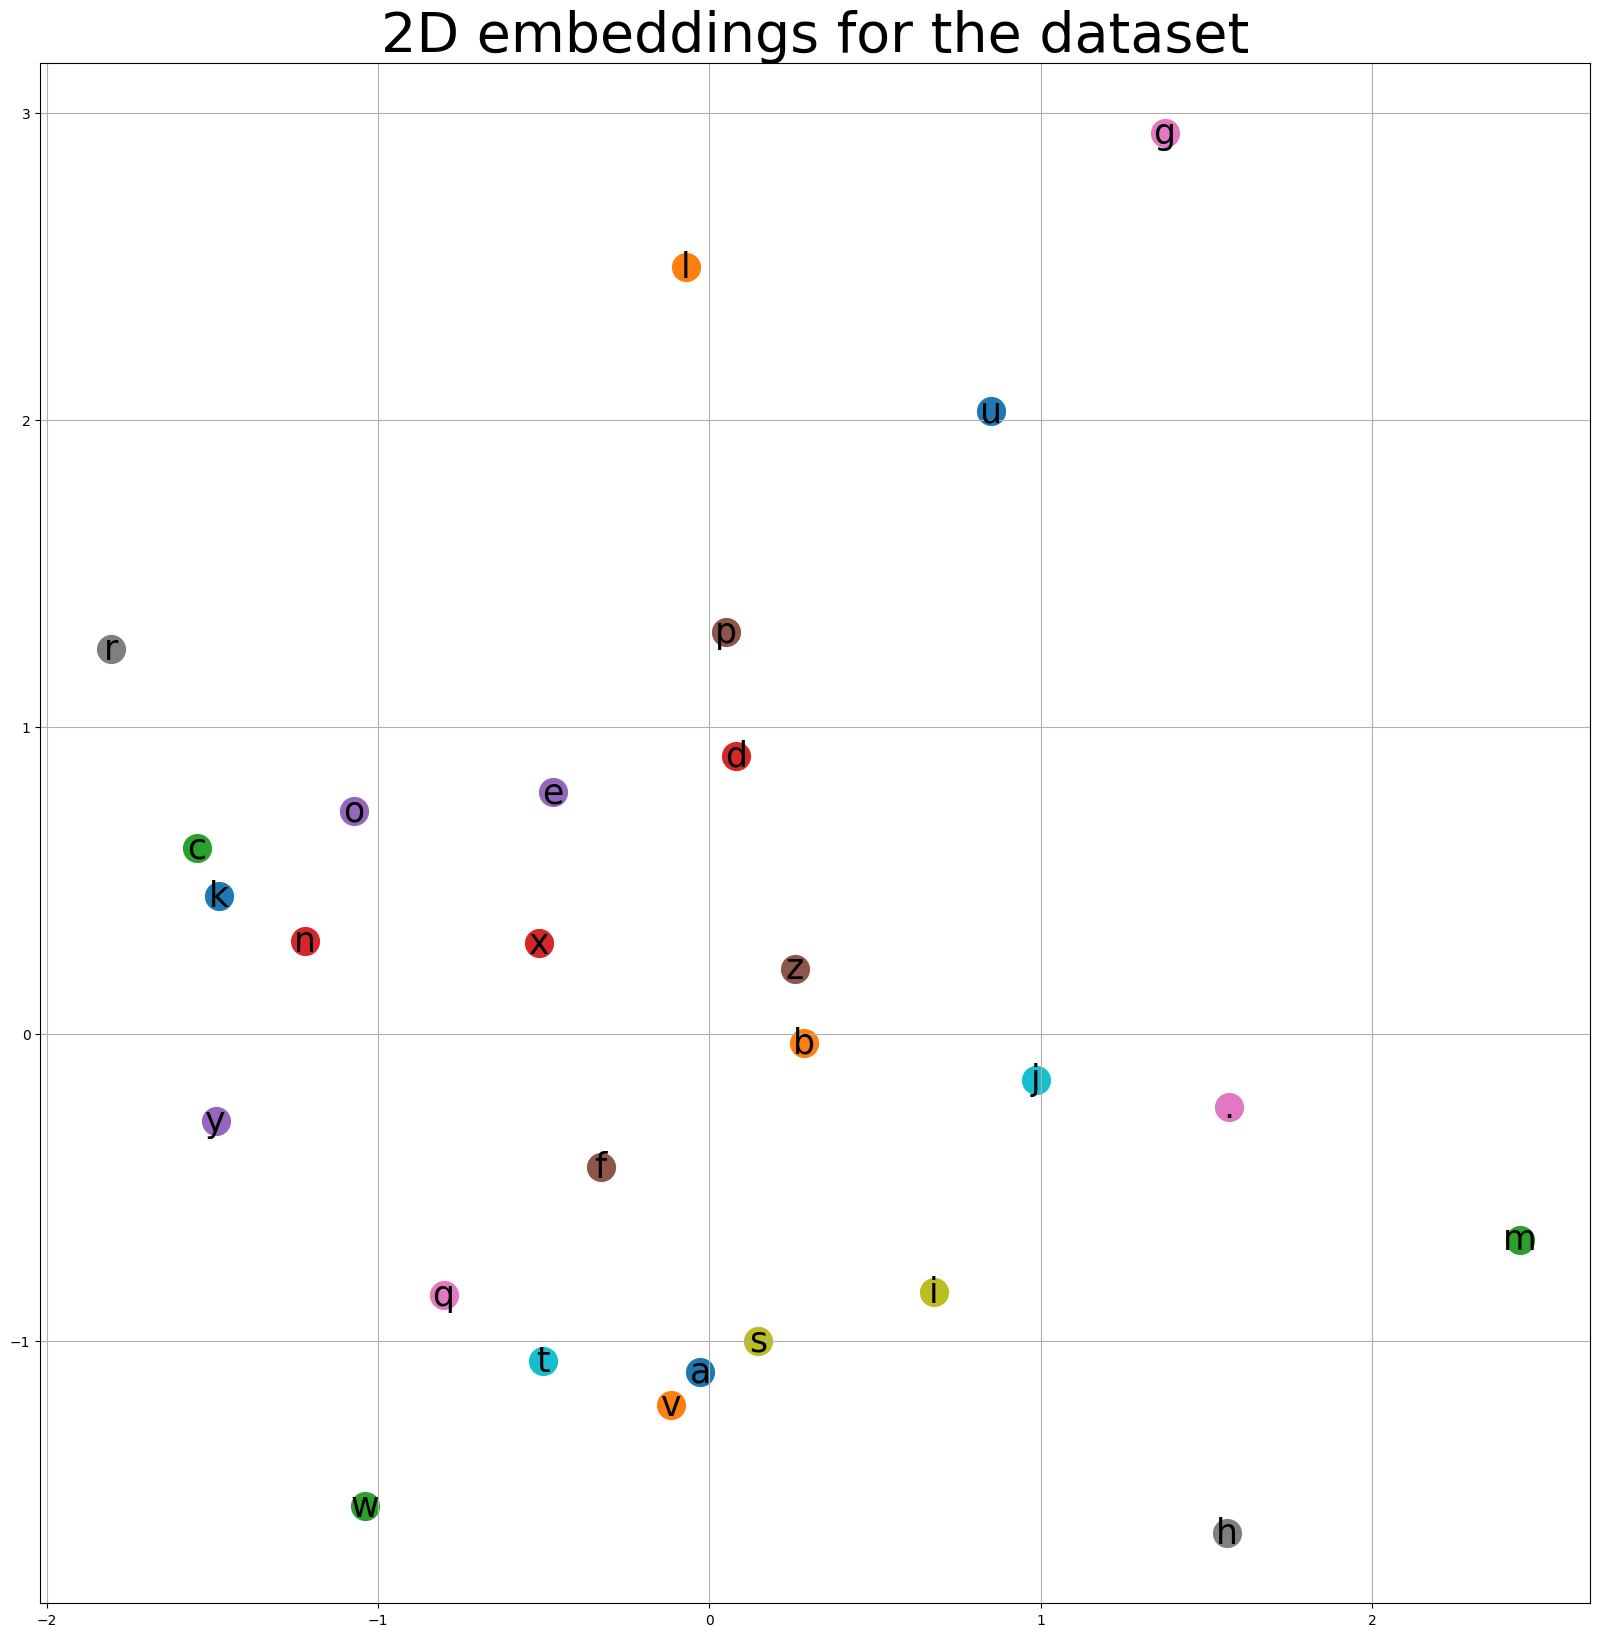

In [247]:
from typing import Dict 

### Lets define a function capable of plotting our 2D embeddings
def plot_embeddings(embed_matrix: torch.tensor, i2s: Dict, figsize=(10,10), character_fontsize: int = 10, tit_size: int = 20, emb_size: int=8**2, draw: bool = False):
    with torch.no_grad():
        fig = plt.figure(figsize=figsize)
        for idx, character in i2s.items():
            emb_vector = embed_matrix[idx,:]
            character = i2s[idx]
            plt.scatter(emb_vector[0], emb_vector[1], s=emb_size)
            plt.text(emb_vector[0], emb_vector[1], character, va="center", ha="center", fontsize=character_fontsize)
        plt.grid(True)
        plt.title("2D embeddings for the dataset", fontsize=tit_size, color="black")
        if draw:
            plt.draw()
        else:
            plt.close()

# Now we plot the initial embeddings
plot_embeddings(embed_matrix=C, i2s=i_to_s, emb_size = 400, figsize=(20,20), character_fontsize=25, tit_size=40, draw=False)

In [248]:
##### We can hereby create our embeddings from the embedding vector C
# We can simply take our X (which here is our 32 examples from the first five words) from our dataset and look at the characters in each of them
print(f"Our first example of X is: {X[0]}, which maps to: {[i_to_s[int(i)] for i in X[0]]}")
print(f"In our embedding space that gets mapped to the three 2D vectors:\n{C[X[0]]}")
print(f"\nOur third example of X is: {X[2]}, which maps to: {[i_to_s[int(i)] for i in X[2]]}")
print(f"In our embedding space that gets mapped to the three 2D vectors:\n{C[X[2]]}")

# Index into our embedding vector with all of our dataset examples to create the embedding spaced matrix 
emb = C[X]                                                          # Index into our embedding vector
print(f"\nHence, as we have {X.shape[0]} context sequences, each with a block size of {X.shape[1]}, the new shape of our embeddings is {emb.shape}")

Our first example of X is: tensor([0, 0, 0]), which maps to: ['.', '.', '.']
In our embedding space that gets mapped to the three 2D vectors:
tensor([[ 1.5674, -0.2373],
        [ 1.5674, -0.2373],
        [ 1.5674, -0.2373]])

Our third example of X is: tensor([ 0,  5, 13]), which maps to: ['.', 'e', 'm']
In our embedding space that gets mapped to the three 2D vectors:
tensor([[ 1.5674, -0.2373],
        [-0.4713,  0.7868],
        [ 2.4448, -0.6701]])

Hence, as we have 32 context sequences, each with a block size of 3, the new shape of our embeddings is torch.Size([32, 3, 2])


In [249]:
##### Now create the layers of our model 
num_neurons_pr_layer = 100
num_input_features = emb.shape[1] * emb.shape[2]

# Create the layers 
W1 = torch.randn((num_input_features, num_neurons_pr_layer))
b1 = torch.randn(num_neurons_pr_layer)

In [250]:
##### Compute the output of the first layers hidden state
# Here we compute the output the tanh nonlinearity after the X*W+b of the first layer 

### Before we can compute the output we have to fix the dimensionality of the tensors.
# Our embedding matrix is 3D with a shape (32, 3, 2). Our linear layer is 2D with a shape (6, 100). 
# Hence, we need to convert emb from (32,3,2) into (32,6). This can be done in many ways.
# emb.view(-1, num_input_features) == torch.cat(torch.unbind(emb, dim=1), dim=1) == torch.reshape(32, 6)
# torch.view() here is the most efficient one, as this doesn't create new memory, it is only the stride and placement of the tensor inside a torch tensor 
# Hence, emb.view() doesn't create a new tensor and doesn't in_place edit the dimensionality of 'emb', which is why it is the most efficient method. 

### Note, for the addition of the bias neurons, we have to make sure that the broadcast is happening on the correct dimension
# We have (emb @ W1) with shape (32, 100) and bias b1 with shape 100.
# When broadcasting, we get:
# 32, 100   ->   32, 100   ->   32, 100
#     100   ->    1, 100   ->   32, 100
# Hence, the broadcast will first align on the right dimensions, then create a new size-1 dimension, and then copy vertically along these rows, before performing an elementwise addition.
# This means, that for this scenario, the broadcasting will work as expected -> it is just nice to double check. 

# Compute the output of the first layer 
h = torch.tanh((emb.view(-1, num_input_features) @ W1) + b1)

print(f"Now the output of the first layer is computed to be of shape {h.shape}, with values:\n{h}")

Now the output of the first layer is computed to be of shape torch.Size([32, 100]), with values:
tensor([[-0.0773,  0.9759,  0.9995,  ..., -0.3052, -0.9998,  0.9473],
        [ 0.5234,  0.5044,  0.9399,  ...,  0.5273, -0.9620, -0.5977],
        [-0.7100,  0.9983,  1.0000,  ..., -0.5545, -0.9968, -0.1370],
        ...,
        [-0.9727, -0.4727,  0.9951,  ...,  0.3042, -0.8206,  0.9132],
        [-0.9407,  0.2961,  0.5434,  ..., -0.6694, -0.9903,  0.9983],
        [-0.9508,  0.5951, -0.2560,  ..., -0.8664, -1.0000, -0.6236]])


In [251]:
##### Initializing the weights and biases of the second (and final) layer 
W2 = torch.randn((num_neurons_pr_layer, num_classes))
b2 = torch.randn(num_classes)

In [252]:
##### Compute the logits (log-counts) as the output of the second layer of the MLP 
logits = h @ W2 + b2

print(f"Now we have computed the outputs of the second layer, i.e. the logits of our MLP. \nThe logits are of shape {logits.shape}")

Now we have computed the outputs of the second layer, i.e. the logits of our MLP. 
The logits are of shape torch.Size([32, 27])


In [253]:
##### Then we can compute the counts by undoing the log, i.e. by exponentiating the logits
# Then we can compute the output probabilities by using a softmax function 
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)            # Remember keepdims=True in order to ensure broadcasting in the right direction when dividing 

print(f"Now the probabilities (i.e. final output) of the model has been computed. We have an output shape of probs.shape: {prob.shape}")

Now the probabilities (i.e. final output) of the model has been computed. We have an output shape of probs.shape: torch.Size([32, 27])


In [254]:
##### Hence, now we can compute the loss. We will again be using the Negative Log Likelihood loss function 
# We take the log of the probabilities as log numbers will be more easy to work with compared to raw probabilities, as: log(a*b*c) = log(a)+log(b)+log(c) 
# As probabilities are values between [0, 1], then the log of these probabilities will be negative, therefore we negate the value of the loss 
# We then take the mean of the loss over the entire batch, as we then have a single value for the loss, which we can then use for backpropagation 

loss = -prob[torch.arange(X.shape[0]), Y].log().mean()      # Compute the NLL loss 

##### Compute the cross_entropy loss using PyTorch
"""
This is equivalent to computing the negative log likelihood loss
However, PyTorch built in loss functions are preferable for a number of reasons:
      1)  Memory efficiency:
          Computing logits, counts, probs explicitly (as we do now) creates many new tensors in memory. PyTorch will used fused kernels to compute the loss all at once.
      2)  Backpropagation stability:
          The fused kernels from PyTorch will not only not create new memory, but will also make the backpropagation much simpler, as the fused kernel will have only one derivative,
          compared to passing gradients through all intermediate expressions ==> this makes the gradient update more stable 
      3)  Numerical stability: 
          Computing our counts like we do know will risk us running into numerical stability issues due to how the exp function works; i.e. taking exp to a very negative number gives an output
          very close to 0. However, taking exp to a very large number outputs "inf" due to the loss of numerical range in our floating point systems.
          In order to avoid these issues, the cross entropy implementation in PyTorch will use the fact that the exponentiation counting over all logits is equivalent no matter the absolute size
          of the entries in each of the logits; i.e. => softmax([0, 1, 2, 3]) == softmax([0, 1, 2, 3] - 3).
          Hence, we can offset the logits with any arbitrary constant value, that we would want, because of the normalization.
          Hence, the PyTorch implementation will subtract the maximum value of the logits tensor before doing any computations, in order to work only with negative numbers, as they will simply
          be very close to 0 (which is fine) when doing the 'exp', instead of risking numerical errors 
"""
torch_loss = F.cross_entropy(logits, Y) 


print(f"Now we have computed the NLL loss to be: {loss.item():.4f}.\nThe Torch implementation computes a loss of {torch_loss.item():.4f}")

Now we have computed the NLL loss to be: 26.4596.
The Torch implementation computes a loss of 26.4596


In [255]:
### Test the correction of the logits with respect to the aforementioned symmetri in the normalization
# Iterate through a few different logits lists 
for new_logits_val in [-90, 4, 90]:                                                             # Iterate through the list of [-90, 4, 90]
    logits_example = torch.tensor([-25, 2] + [new_logits_val])                                  # Append the new logit val to the list of [-25, 2]
    counts_example = logits_example.exp()                                                       # Compute the log counts by taking the exponential of the logits 
    probs_example = counts_example / counts_example.sum()                                       # Compute the probabilities by normalizing (softmax)
    counts_corrected = (logits_example - logits_example.max()).exp()                            # Correct the counts, by offsetting the logits list with max(logits)
    probs_corrected = counts_corrected / counts_corrected.sum()                                 # Compute the corrected probabilities 
    
    # Print the results - notice that for the first iterations counts == counts_corrected, and hence, also probs == probs_corrected 
    print(f"{''.join(['_' for _ in range(171)])}\n" + 
          f"Logits: {([f'{x.item():d}' for x in logits_example])}\n" + 
          f"Counts: {[f'{x.item():.3f}' for x in counts_example]}".ljust(39) +
          f"Probs: {[f'{x.item():.3f}' for x in probs_example]}".ljust(37) +
          f"Corrected counts: {[f'{x.item():.4f}' for x in counts_corrected]}".ljust(51) +
          f"Corrected probs: {[f'{x.item():.3f}' for x in probs_corrected]}\n" +
          f"{''.join(['_' for _ in range(171)])}")


___________________________________________________________________________________________________________________________________________________________________________
Logits: ['-25', '2', '-90']
Counts: ['0.000', '7.389', '0.000']    Probs: ['0.000', '1.000', '0.000']   Corrected counts: ['0.0000', '1.0000', '0.0000']   Corrected probs: ['0.000', '1.000', '0.000']
___________________________________________________________________________________________________________________________________________________________________________
___________________________________________________________________________________________________________________________________________________________________________
Logits: ['-25', '2', '4']
Counts: ['0.000', '7.389', '54.598']   Probs: ['0.000', '0.119', '0.881']   Corrected counts: ['0.0000', '0.1353', '1.0000']   Corrected probs: ['0.000', '0.119', '0.881']
______________________________________________________________________________________

In [256]:
# ------------ now made respectable :) ---------------

In [257]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [258]:
def generate_parameters(random_seed: int = 2147483648, emb_dim: int = 2, num_hidden_neurons: int = 100, block_size: int = 3, num_classes: int = len(i_to_s), return_generator: bool = False):
    g = torch.Generator().manual_seed(random_seed)          # for reproducibility

    # Create all the layers and trainable parameters
    C = torch.randn((num_classes, emb_dim), generator=g)
    W1 = torch.randn((emb_dim*block_size, num_hidden_neurons), generator=g)
    b1 = torch.randn(num_hidden_neurons, generator=g)
    W2 = torch.randn((num_hidden_neurons, num_classes), generator=g)
    b2 = torch.randn(num_classes, generator=g)

    # Assure all parameters have set "required_grad" to True and return the parameters 
    for p in [C, W1, b1, W2, b2]:
        p.requires_grad = True
    return_list = [C, W1, b1, W2, b2]
    if return_generator:
        return_list.append(g)
    return tuple(return_list)


# Compute the total number of parameters in our network 
C, W1, b1, W2, b2 = generate_parameters()
parameters = [C, W1, b1, W2, b2]
num_parameters = sum(p.nelement() for p in parameters)          # number of parameters in total
print(f"This means that with the embedding dimension {C.shape[1]} and a two layer MLP with {W1.shape[1]} in each layer, we end up at {num_parameters} trainable parameters")

This means that with the embedding dimension 2 and a two layer MLP with 100 in each layer, we end up at 3481 trainable parameters


In [259]:
### Define the training function
from typing import Union, List, Tuple
import math 

# This we will use to both showcase three examples:
# 1) How to perform a learning rate search? i.e. we will search for the proper learning rate 
# 2) What happens when we overfit with just the 32 sequences from our X array, i.e. to check that the model is capable of learning
# 3) Training the model on the entire dataset 



def train_func(inp_data: torch.tensor, targets: torch.tensor, emb_matrix: torch.tensor = C, batch_size: int = 32, num_iterations: int = 20,
        lr_scheduler: Union[torch.tensor, None] = None, lr: Union[torch.tensor, None] = 1e-4, regenerate_parameters: bool = True) -> Tuple[List, List, List, List]:
    # Initiating lists to store the data that we want to keep 
    lri = []
    lossi = []
    stepi = []

    # Regenerate the parameters of the network at random state 
    emb_matrix, W1, b1, W2, b2, g = generate_parameters(return_generator=True)
    parameters = [emb_matrix, W1, b1, W2, b2]

    # Iterating through all the selected iterations 
    if lr_scheduler is None:
        lr_scheduler = torch.full((num_iterations,), lr)                        # Repeat the provided learning rate for all iterations 
    for i in range(num_iterations):
        # Forward pass 
        idx = torch.randint(0, inp_data.shape[0], (batch_size,), generator=g)   # Create integer index array for creating stochastic mini-batches 
        emb = emb_matrix[inp_data[idx]]                                         # (32, 3, 10) --> Read the embedding vectors of the randomly selected examples for the current iteration 
        h = torch.tanh(emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1 + b1)       # (32, 200)   --> Compute the output of the first hidden layer of our MLP model 
        logits = h @ W2 + b2                                                    # (32, 27)    --> Compute the logits of the forward pass 
        loss = F.cross_entropy(logits, targets[idx])                            # Compute the NLL loss (equal to the cross entropy) using the efficient pytorch implementation 

        # Backward pass 
        # According to Karparthy, setting the gradient to None is more efficient than p.grad = 0, when using PyTorch .backward() method 
        for p in parameters:
            p.grad = None
        loss.backward()                                 # Compute the new gradients for all parameters 

        # Update all the parameters 
        lr = lr_scheduler[i]
        for p in parameters:
            p.data += -lr *p.grad 
        
        # Track the stats
        lri.append(lr)
        stepi.append(i)
        lossi.append(loss.log10().item())
    
    # Return the lists of stats
    return lri, stepi, lossi, parameters

#### Perform a search for the optimal learning rate

In [260]:
#### Perform a search for the optimal learning rate 
num_iterations=2000
lri_lr_finder, _, lossi_lr_finder, _ = train_func(inp_data=X, targets=Y, regenerate_parameters=True, lr_scheduler=torch.logspace(-4, 0, num_iterations), num_iterations=num_iterations)

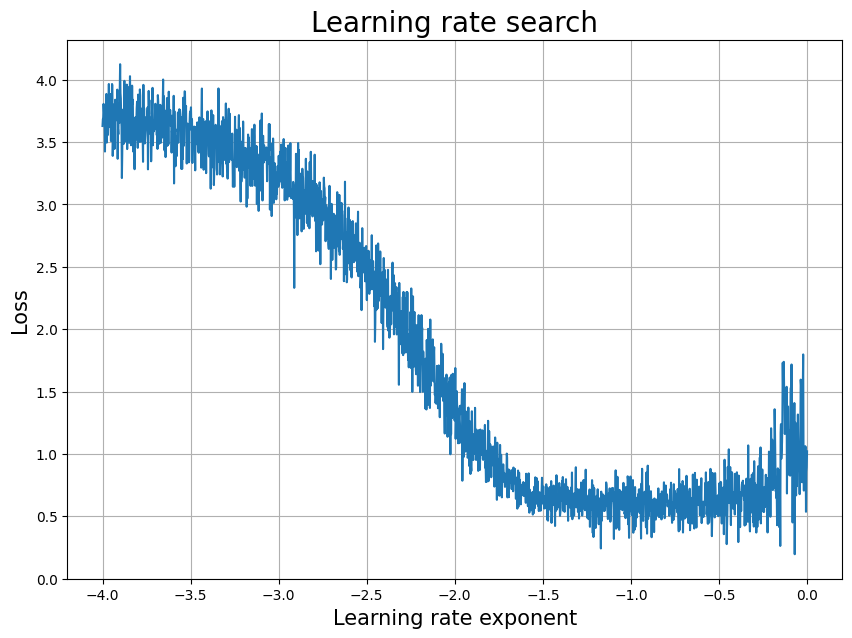

In [261]:
# Plot the learning rate finder plot
plt.figure(figsize=(10,7)); plt.plot([x.log10() for x in lri_lr_finder], [math.exp(x) for x in lossi_lr_finder]); plt.grid(True); plt.title("Learning rate search", fontsize=20); plt.xlabel("Learning rate exponent", fontsize=15); plt.ylabel("Loss", fontsize=15); plt.draw()

#### Overfit with a single batch

In [262]:
#### Perform a search for the optimal learning rate 
num_iterations=250
_, stepi_overfit, lossi_overfit, _ = train_func(inp_data=X, targets=Y, regenerate_parameters=True, lr=10**-1.5, num_iterations=num_iterations, batch_size=X.shape[0])

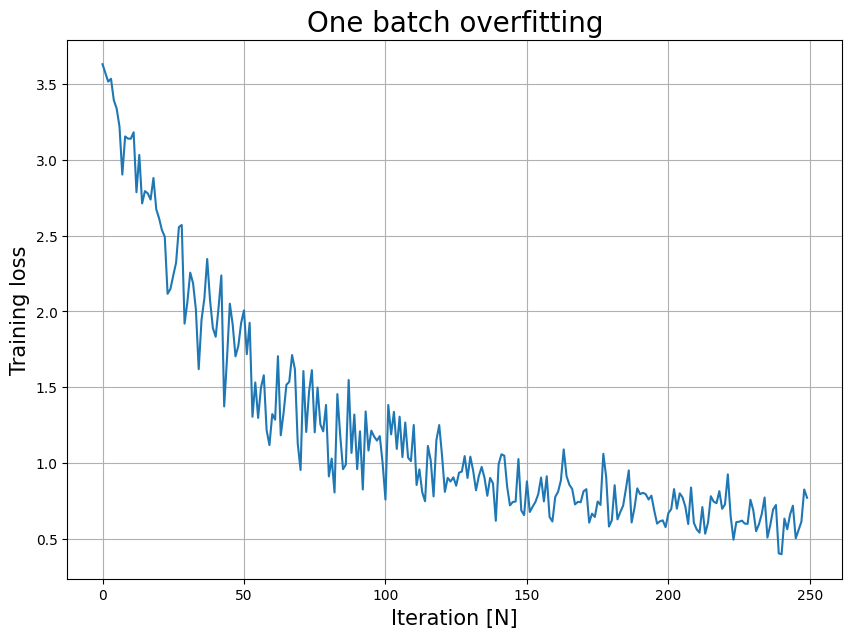

In [263]:
# Plot the learning curve for the situation where we only overfit a single batch of the 32 example sequences from X 
plt.figure(figsize=(10,7)); plt.plot(stepi_overfit, [math.exp(x) for x in lossi_overfit]); plt.grid(True); plt.title("One batch overfitting", fontsize=20); plt.xlabel("Iteration [N]", fontsize=15); plt.ylabel("Training loss", fontsize=15); plt.draw()

#### Proper training on the entire dataset

In [264]:
#### Perform a search for the optimal learning rate 
num_iterations=5000
lr_train, stepi_train, lossi_train, parameters = train_func(inp_data=Xtr, targets=Ytr, regenerate_parameters=True, lr_scheduler=torch.logspace(-3, -1, num_iterations).flip(dims=[0]), num_iterations=num_iterations)
# lr_train, stepi_train, lossi_train, parameters = train_func(inp_data=Xtr, targets=Ytr, regenerate_parameters=True, lr=0.1, num_iterations=num_iterations)
C, W1, b1, W2, b2 = parameters

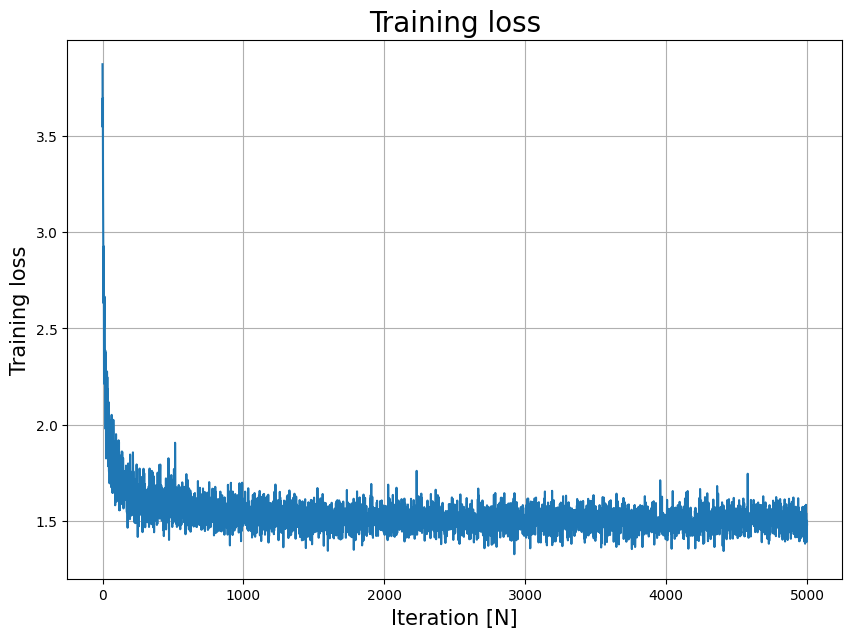

In [265]:
# Plot the learning curve for the situation where we only overfit a single batch of the 32 example sequences from X 
plt.figure(figsize=(10,7)); plt.plot(stepi_train, [math.exp(x) for x in lossi_train]); plt.grid(True); plt.title("Training loss", fontsize=20); plt.xlabel("Iteration [N]", fontsize=15); plt.ylabel("Training loss", fontsize=15); plt.draw()

In [266]:
##### Compute the training loss 
# This is simply done by a single forward pass 
emb = C[Xtr]                                                            # Embeddings for the entire training dataset 
h = torch.tanh(emb.view(-1, C.shape[1]*block_size) @ W1 + b1)           # Output after feeding the entire training dataset through the first model layer 
logits = h @ W2 + b2                                                    # Output after feeding the entire training dataset through the second model layer 
loss = F.cross_entropy(logits, Ytr)                                     # The training loss 
print(f"The training loss of the entire training set is: {loss.item():.5f}")

The training loss of the entire training set is: 2.55898


In [267]:
##### Compute the dev (validation) loss 
emb = C[Xdev]                                                           # Embeddings for the entire validation dataset 
h = torch.tanh(emb.view(-1, C.shape[1]*block_size) @ W1 + b1)           # Output after feeding the entire validation dataset through the first model layer 
logits = h @ W2 + b2                                                    # Output after feeding the entire validation dataset through the second model layer 
loss = F.cross_entropy(logits, Ydev)                                    # The validation loss 
print(f"The validation loss of the entire validation set is: {loss.item():.5f}")

The validation loss of the entire validation set is: 2.55286


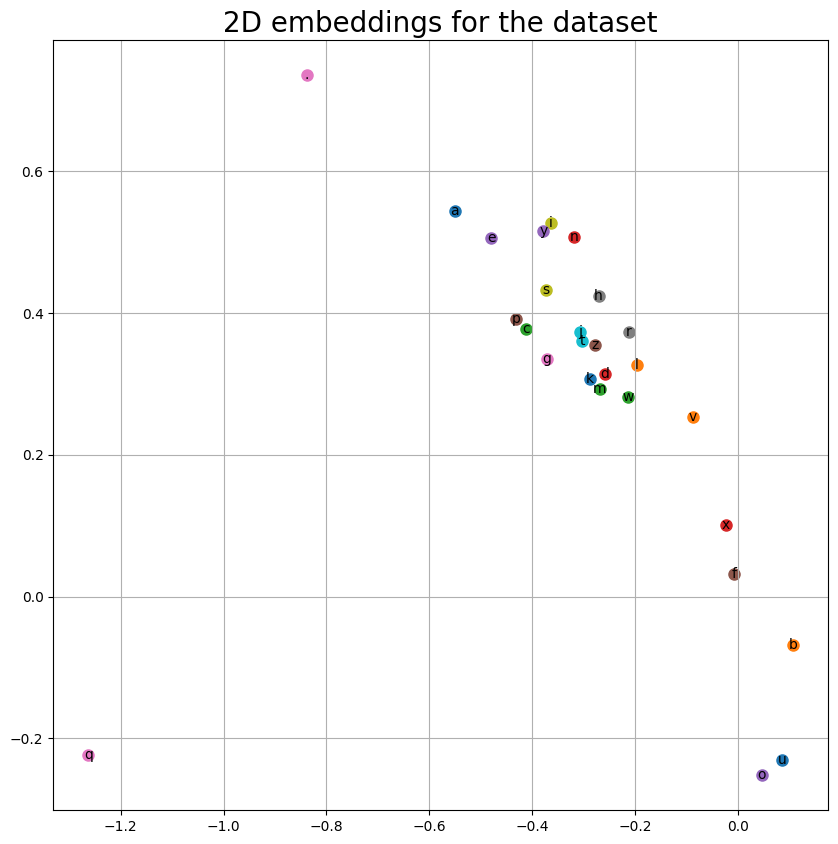

In [268]:
# Visualize the embeddings of the C matrix in 2D
plot_embeddings(embed_matrix=C, i2s=i_to_s, draw=True)

In [272]:
##### Inference scripting
# Sample from the model

num_samples = 20

g = torch.Generator().manual_seed(2147483647)

for _ in range(num_samples):
    
    out = []
    context = [0] * block_size                    # initialize with all dots => ...
    while True:
      emb = C[torch.tensor([context])]            # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)   # Compute the output of the first layer, h.shape = (1, num_)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(i_to_s[i] for i in out))

junide.
janasar.
paliay.
aiia.
koi.
rltolia.
satee.
kilanaauranilenhas.
deyainrwi.
tansn.
yieaylarte.
karaumtsyfodtare.
ponis.
mah.
jaelieora.
yaehon.
kaeaaedinehimiii.
wynin.
agaasnhas.
ihouszlh.
